In [1]:
import os
import sys
import cv2
import glob 
import torch
import random 
import resource 
import numpy as np
from math import exp
import torch.nn as nn 
from PIL import Image
from models.memae import *
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
# rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
# resource.setrlimit(resource.RLIMIT_NOFILE, (4096, rlimit[1]))
 

In [2]:
def gaussian(window_size, sigma):
    """
    Args:
        window_size: Size of Gaussian window
        sigma: mean for the gaussian

    Returns:
        gauss. a gaussian matrix with mean equal to sigma and size equal to window size 
    """
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    """
    Args:
        window_size: Size of Gaussian window
        channel: number of channels in the gaussian filter

    Returns:
        window: Gaussian tensor
    """
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = False):
    """
    Args:
        img1: image one to be compared
        img2: image two to be compared
        window: the Gaussian window
        window_size: size of the Gaussian Window
        channel: number of output channels
        size_average: take mean of the final similarity matrix or not

    Returns:
        ssim_map: Structural similarity index of two images
    """
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average and False: 
        return ssim_map.mean()
    else:
        return ssim_map
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    """ 
    Class for SSIM loss 
      
    Attributes: 
        size_average: Take mean of the loss or not 
        window_size: size of similarity window 
    """
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)
         
    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel

        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

 

In [3]:
class MemDataset(Dataset):
    """Memory Auto Encoder Dataset"""

    def __init__(self,root_dir,start,end,train=True):
        """
        Args:
            root_dir : Directory with all the images.
            start : starting index of images to include in this set
            end : ending index of images to include in this set
            train : train or test
        """
        self.transform=transforms.Compose([    transforms.Resize((98,98)), 
                                               transforms.Grayscale(num_output_channels=1),
                                               transforms.ToTensor()
                                           ])
        self.train = train
        self.dataset = glob.glob(root_dir)[start:end] 
       

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img_name = self.dataset[idx]
        im = np.array(Image.open(img_name))  
        im = Image.fromarray(im) 
        im = self.transform(im)
        return im,im
    
dataset = MemDataset('../defect/datasets/infineon/train_memae/train/*',0,1500)
test_good = MemDataset('../defect/datasets/infineon/train_memae/test/*',0,10000,False)
test_bad = MemDataset('../defect/datasets/infineon/test/baad/*',00,1000,False)

print ("Train Good",dataset.__len__(), "\nTest defective", test_bad.__len__(),"\nTest good", test_good.__len__())

dl = torch.utils.data.DataLoader(dataset,batch_size=64, shuffle=True,
                                             num_workers=4)
dl_test_bad = torch.utils.data.DataLoader(test_bad,batch_size=1, shuffle=False,
                                             num_workers=4)
dl_test_good = torch.utils.data.DataLoader(test_good,batch_size=1, shuffle=False,
                                             num_workers=4)


Train Good 1500 
Test defective 462 
Test good 462


In [19]:
import torchvision
model = MEMAE(300).cuda()
model.load_state_dict(torch.load("./ckpts/l2_seg_ckpt/60.pt")) 
resnet = torchvision.models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))


In [20]:
 
def train(model,dataloader,criteria,optimizer,train=True,step=100):
    losses = list() 
    if not train:
        model.eval()
    else:
        model.train()
    for i,(im,lab) in enumerate(dataloader):
        optimizer.zero_grad() 
        outputs = model(im.cuda())  
        #Minimize the similarity difference
        loss =  criteria(outputs, lab.cuda()) 
        refiner_output = criteria(outputs,model(outputs))
        refined_loss = cv2.GaussianBlur(loss.clone().cpu().detach().numpy()[0].reshape(98,98),(9,9),0) -  refiner_output.cpu().detach().numpy()[0].reshape(98,98)
        refined_loss_sorted = np.sort(refined_loss.reshape(-1)) 
#         losses.append(np.median(refined_loss_sorted)*np.median(refined_loss_sorted[-50:])) 
        phase = "Train" if train else "Test" 
        if i % 10 == 0:
             print (phase," Iteration: ",i,"LOSS : ",np.mean(refined_loss),"min:",np.min(refined_loss),"max:",np.max(refined_loss)\
               ,"med:",np.median(refined_loss),"zero:",refined_loss[refined_loss==0].shape)
        
        if i % step == 0 and  not train:
            difference = np.abs(im.cpu().detach().numpy().reshape(98,98) - outputs.cpu().detach().numpy().reshape(98,98))
            print (phase," Iteration: ",i,"LOSS : ",np.mean(refined_loss),"min:",np.min(refined_loss),"max:",np.max(refined_loss)\
               ,"med:",np.median(refined_loss),"zero:",refined_loss[refined_loss==0].shape) 
            inn = im.cpu().detach().numpy()[0]
            inn = np.transpose(inn,(1,2,0)) 
            outputs = outputs.cpu().detach().numpy()[0]  
            outputs[outputs>1]=1
            outputs = np.transpose(outputs,(1,2,0))[:,:,0] 
             
            difference[difference<0.02]=0
            thr = cv2.GaussianBlur(difference,(19,19),0)
            _,thr = cv2.threshold((thr*255).astype('uint8'),0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            difference*=thr
            losses.append((difference,inn)) 
        if train:
            loss.mean().backward()
            optimizer.step()
    
    return losses

def calculate_acc(loss_lists):
    
    neg_np =  (np.array(loss_lists[0]))
    pos_np =  (np.array(loss_lists[1]))
    pos_np *=1000
    neg_np *=1000
    start,end = np.median(pos_np),np.median(neg_np) 
    
    thresholds = np.linspace(start, end, num=1000)
    accuracy = 0
    thres = 0
    print (pos_np.shape,neg_np.shape)
    
    for threh in thresholds: 
        current_acc = ((pos_np[pos_np<threh].shape[0])+(neg_np[neg_np>=threh].shape[0])) / (pos_np.shape[0]+neg_np.shape[0])
        if accuracy < current_acc:
            accuracy = current_acc
            thres  = threh
                                                                                          
    print (accuracy,thres)
    print ("Positive",pos_np[pos_np<thres].shape,"Anomaly",neg_np[neg_np>=thres].shape, "Distribution")
    return accuracy,thres

In [21]:
 
np.set_printoptions(threshold=sys.maxsize)
criteria = nn.MSELoss(reduction='none' ).cuda()
s_loss = SSIM().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)
phases = {"test":[dl_test_bad,dl_test_good],"train":dl}

epoch = 0
max_acc = 0

while True:
    epoch+=1
    print ("Epoch ___________________________________",epoch)
    if epoch ==10000:
        break
    for phase in phases:
        loaders = phases[phase]
        if phase == 'train': 
            continue
            train(model,loaders,criteria,optimizer,True,50)
        else: 
            loss_lists = list()
            for loader in loaders:
                losses = train(model,loader,criteria,optimizer,False,1)
                loss_lists.append(losses)
                break 
            print ("ACCURACY: ",acc, "THRESHOLD: ",thr)

    break 

Epoch ___________________________________ 1
Test  Iteration:  0 LOSS :  5.960686e-05 min: -9.0754016e-05 max: 0.009373846 med: 1.5687874e-05 zero: (0,)
Test  Iteration:  0 LOSS :  5.960686e-05 min: -9.0754016e-05 max: 0.009373846 med: 1.5687874e-05 zero: (0,)
Test  Iteration:  1 LOSS :  2.8883405e-05 min: -0.00031776732 max: 0.0015313787 med: 1.1327643e-05 zero: (0,)
Test  Iteration:  2 LOSS :  6.753736e-05 min: -0.00020104751 max: 0.011272353 med: 1.4421103e-05 zero: (0,)
Test  Iteration:  3 LOSS :  1.9710214e-05 min: -0.00012661087 max: 0.00034268634 med: 1.3817014e-05 zero: (0,)
Test  Iteration:  4 LOSS :  0.00013099598 min: -0.00019677784 max: 0.018414918 med: 1.8075261e-05 zero: (0,)
Test  Iteration:  5 LOSS :  1.9929163e-05 min: -0.00011231239 max: 0.00035591872 med: 1.2811977e-05 zero: (0,)
Test  Iteration:  6 LOSS :  0.00017723058 min: -0.00046060965 max: 0.009060149 med: 1.962186e-05 zero: (0,)
Test  Iteration:  7 LOSS :  6.725593e-05 min: -0.00022729782 max: 0.011238475 med: 

Test  Iteration:  70 LOSS :  0.00015049234 min: -0.00039307732 max: 0.007779884 med: 2.6617596e-05 zero: (0,)
Test  Iteration:  70 LOSS :  0.00015049234 min: -0.00039307732 max: 0.007779884 med: 2.6617596e-05 zero: (0,)
Test  Iteration:  71 LOSS :  3.6306843e-05 min: -0.00017571029 max: 0.00538854 med: 1.271811e-05 zero: (0,)
Test  Iteration:  72 LOSS :  2.9989797e-05 min: -6.241331e-05 max: 0.0007449021 med: 1.42459885e-05 zero: (0,)
Test  Iteration:  73 LOSS :  0.00010068882 min: -0.00039169868 max: 0.010404775 med: 1.7247672e-05 zero: (0,)
Test  Iteration:  74 LOSS :  2.8911812e-05 min: -2.9480903e-05 max: 0.0020882303 med: 1.0371921e-05 zero: (0,)
Test  Iteration:  75 LOSS :  2.5774363e-05 min: -0.00022296754 max: 0.00067629974 med: 1.4254678e-05 zero: (0,)
Test  Iteration:  76 LOSS :  0.00013661185 min: -0.0008151905 max: 0.007049779 med: 1.6491711e-05 zero: (0,)
Test  Iteration:  77 LOSS :  4.6971818e-05 min: -0.00016653573 max: 0.0027286434 med: 1.09230405e-05 zero: (0,)
Test  I

Test  Iteration:  145 LOSS :  9.193663e-05 min: -0.0002069311 max: 0.012528741 med: 1.2703619e-05 zero: (0,)
Test  Iteration:  146 LOSS :  3.688005e-05 min: -0.00016591245 max: 0.0011263352 med: 1.5053195e-05 zero: (0,)
Test  Iteration:  147 LOSS :  8.9272304e-05 min: -0.00013502654 max: 0.0025867466 med: 1.652996e-05 zero: (0,)
Test  Iteration:  148 LOSS :  0.00015588879 min: -0.0015696982 max: 0.0060885 med: 1.19089855e-05 zero: (0,)
Test  Iteration:  149 LOSS :  3.383723e-05 min: -9.743073e-05 max: 0.0035500147 med: 1.1720385e-05 zero: (0,)
Test  Iteration:  150 LOSS :  0.0002400707 min: -0.00019261264 max: 0.015286724 med: 3.0365507e-05 zero: (0,)
Test  Iteration:  150 LOSS :  0.0002400707 min: -0.00019261264 max: 0.015286724 med: 3.0365507e-05 zero: (0,)
Test  Iteration:  151 LOSS :  2.0707597e-05 min: -6.403336e-05 max: 0.0005715601 med: 1.239252e-05 zero: (0,)
Test  Iteration:  152 LOSS :  4.5343244e-05 min: -0.00036629342 max: 0.005178835 med: 1.2559156e-05 zero: (0,)
Test  Ite

Test  Iteration:  216 LOSS :  6.176327e-05 min: -9.763695e-05 max: 0.009242211 med: 1.3023209e-05 zero: (0,)
Test  Iteration:  217 LOSS :  0.0001420553 min: -0.0024587954 max: 0.006850005 med: 6.262998e-06 zero: (0,)
Test  Iteration:  218 LOSS :  5.7080644e-05 min: -0.00016505842 max: 0.0066403835 med: 1.5889447e-05 zero: (0,)
Test  Iteration:  219 LOSS :  5.4707958e-05 min: -0.00023489492 max: 0.0038416155 med: 1.2072658e-05 zero: (0,)
Test  Iteration:  220 LOSS :  0.00019289048 min: -0.0004044232 max: 0.017017122 med: 1.8405946e-05 zero: (0,)
Test  Iteration:  220 LOSS :  0.00019289048 min: -0.0004044232 max: 0.017017122 med: 1.8405946e-05 zero: (0,)
Test  Iteration:  221 LOSS :  0.0001128677 min: -0.00039804963 max: 0.005688498 med: 1.8149267e-05 zero: (0,)
Test  Iteration:  222 LOSS :  3.428818e-05 min: -0.00026772456 max: 0.00569264 med: 7.5312814e-06 zero: (0,)
Test  Iteration:  223 LOSS :  2.7572867e-05 min: -3.5108395e-05 max: 0.0005488105 med: 1.3686737e-05 zero: (0,)
Test  It

Test  Iteration:  292 LOSS :  7.667395e-05 min: -0.00012589095 max: 0.0071825897 med: 9.523159e-06 zero: (0,)
Test  Iteration:  293 LOSS :  3.8101498e-05 min: -6.708632e-05 max: 0.003461817 med: 1.32777695e-05 zero: (0,)
Test  Iteration:  294 LOSS :  0.00012901447 min: -0.0004996547 max: 0.012876011 med: 1.2484357e-05 zero: (0,)
Test  Iteration:  295 LOSS :  3.7836115e-05 min: -6.461444e-05 max: 0.0037295006 med: 1.1198895e-05 zero: (0,)
Test  Iteration:  296 LOSS :  2.9900437e-05 min: -0.00018106803 max: 0.00031223815 med: 1.6799619e-05 zero: (0,)
Test  Iteration:  297 LOSS :  9.828692e-05 min: -0.0005434189 max: 0.005586085 med: 2.4412895e-05 zero: (0,)
Test  Iteration:  298 LOSS :  9.559378e-05 min: -0.002221217 max: 0.0031342027 med: 2.1241045e-05 zero: (0,)
Test  Iteration:  299 LOSS :  2.6702837e-05 min: -0.00012395902 max: 0.0017304571 med: 1.1651857e-05 zero: (0,)
Test  Iteration:  300 LOSS :  0.00012376983 min: -0.000554594 max: 0.0016947201 med: 1.8321429e-05 zero: (0,)
Test 

Test  Iteration:  363 LOSS :  2.9372251e-05 min: -8.3153674e-05 max: 0.0017514774 med: 1.2616267e-05 zero: (0,)
Test  Iteration:  364 LOSS :  0.00012599962 min: -0.00051813887 max: 0.0056731175 med: 1.2156226e-05 zero: (0,)
Test  Iteration:  365 LOSS :  0.0003444692 min: -0.0021819244 max: 0.0139458515 med: 1.6578178e-05 zero: (0,)
Test  Iteration:  366 LOSS :  0.0005059345 min: -0.00054668856 max: 0.01437132 med: 1.9109793e-05 zero: (0,)
Test  Iteration:  367 LOSS :  6.689904e-05 min: -0.00013806735 max: 0.0035355366 med: 1.5258618e-05 zero: (0,)
Test  Iteration:  368 LOSS :  3.9324266e-05 min: -0.00015424352 max: 0.0016105224 med: 2.3228451e-05 zero: (0,)
Test  Iteration:  369 LOSS :  3.649557e-05 min: -0.00010105334 max: 0.00285516 med: 1.6988335e-05 zero: (0,)
Test  Iteration:  370 LOSS :  3.4924324e-05 min: -0.0002074569 max: 0.0034002063 med: 1.4848247e-05 zero: (0,)
Test  Iteration:  370 LOSS :  3.4924324e-05 min: -0.0002074569 max: 0.0034002063 med: 1.4848247e-05 zero: (0,)
Tes

Test  Iteration:  439 LOSS :  4.36171e-05 min: -0.0019500375 max: 0.0019573271 med: 1.4957173e-05 zero: (0,)
Test  Iteration:  440 LOSS :  2.9288567e-05 min: -0.00013548456 max: 0.0015965297 med: 1.5030249e-05 zero: (0,)
Test  Iteration:  440 LOSS :  2.9288567e-05 min: -0.00013548456 max: 0.0015965297 med: 1.5030249e-05 zero: (0,)
Test  Iteration:  441 LOSS :  3.373206e-05 min: -3.6380614e-05 max: 0.0031958343 med: 1.4866602e-05 zero: (0,)
Test  Iteration:  442 LOSS :  2.6663341e-05 min: -0.00012830563 max: 0.00082565955 med: 1.3417683e-05 zero: (0,)
Test  Iteration:  443 LOSS :  5.109128e-05 min: -8.901434e-05 max: 0.0037918822 med: 1.2533128e-05 zero: (0,)
Test  Iteration:  444 LOSS :  3.3639233e-05 min: -9.285529e-05 max: 0.002712677 med: 1.4013291e-05 zero: (0,)
Test  Iteration:  445 LOSS :  3.9185885e-05 min: -8.941196e-05 max: 0.0036183342 med: 1.6373866e-05 zero: (0,)
Test  Iteration:  446 LOSS :  9.519778e-05 min: -0.00044344072 max: 0.0084510725 med: 1.181349e-05 zero: (0,)
Te

NameError: name 'acc' is not defined

In [22]:
print (len(loss_lists[0]))

462


In [23]:
features = list()
imgs = list()

"""
Extract resnet features of all images
"""
for label,img in loss_lists[0]:
    img = img.reshape(98,98)
    label[label!=0]=1
     
    img = np.stack((img,)*3, axis=-1)
    
    img[label == 1]=np.array([0,1,0])
    imgs.append(img)
    img = np.transpose(img,(2,0,1))
    img = torch.tensor(img).unsqueeze(0)
    output = resnet(img).view(-1).cpu().detach().numpy()
    features.append(output)


In [24]:
np_features = np.stack(features)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3,n_init=1,max_iter=10)
kmeans.fit(np_features)
kmeans.labels_



array([2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 0, 1, 1, 2, 2, 0, 0, 2, 0,
       0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 1, 2, 2, 2, 1, 0, 0, 2, 2, 2,
       1, 2, 0, 0, 0, 2, 1, 1, 2, 0, 2, 2, 2, 0, 1, 2, 2, 2, 0, 2, 0, 2,
       2, 0, 2, 2, 2, 2, 0, 2, 0, 2, 2, 1, 1, 0, 0, 2, 2, 2, 2, 0, 0, 2,
       1, 0, 1, 0, 0, 0, 2, 0, 2, 1, 0, 0, 2, 1, 2, 0, 0, 0, 1, 2, 0, 2,
       2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 1, 0, 2, 1, 2, 1, 2, 2, 2, 0, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 0, 2, 0,
       2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2,
       2, 1, 2, 1, 2, 0, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 1,
       2, 2, 1, 2, 0, 1, 0, 1, 2, 1, 0, 1, 2, 0, 1, 1, 2, 2, 0, 1, 2, 2,
       2, 2, 1, 2, 1, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 2,
       0, 0, 0, 0, 0, 1, 2, 2, 0, 2, 1, 2, 1, 2, 0, 2, 2, 2, 2, 1, 1, 0,
       1, 2, 0, 0, 2, 2, 2, 2, 2, 0, 1, 1, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2,
       2, 0, 0, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2,

(80,)
2


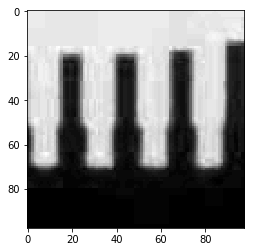

2


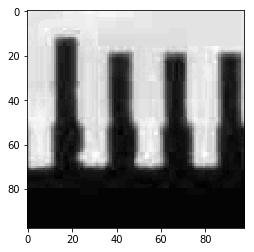

2


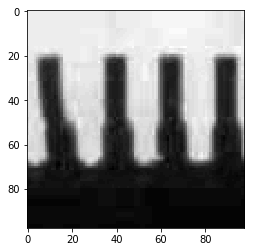

2


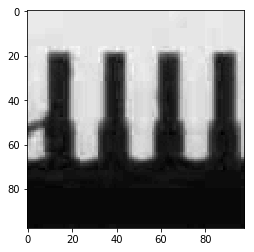

2


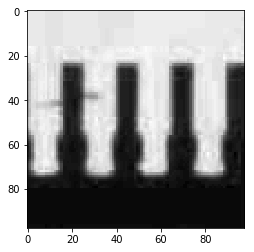

2


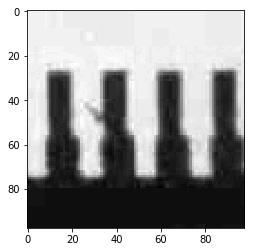

2


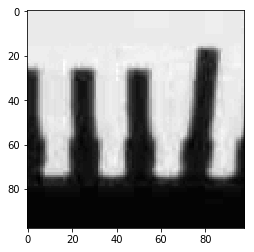

2


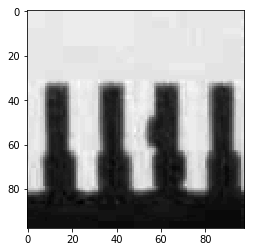

2


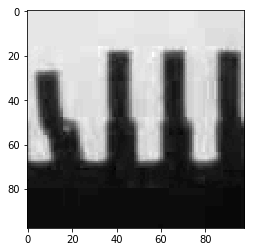

2


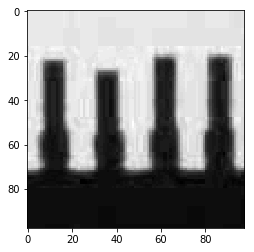

2


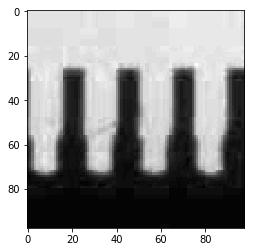

2


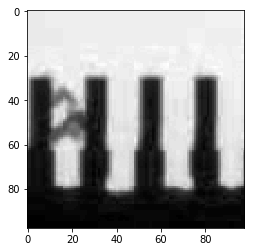

2


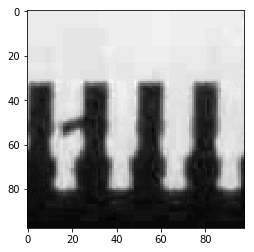

2


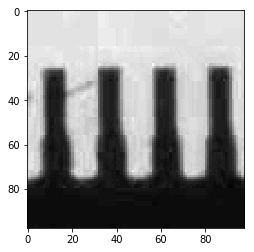

2


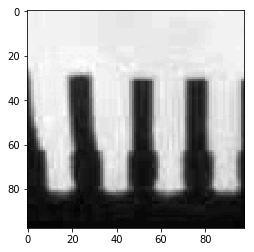

2


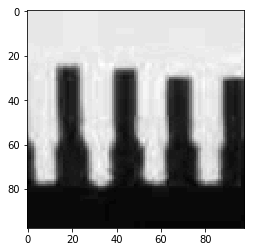

2


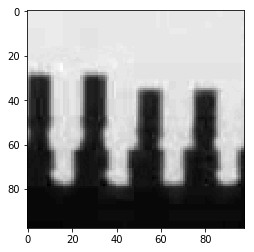

2


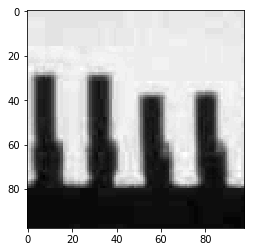

2


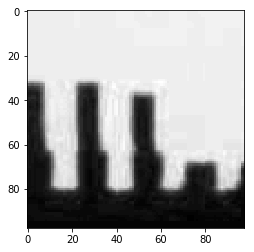

2


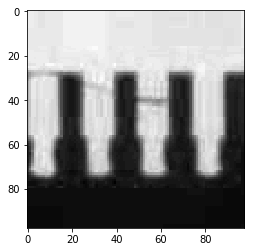

2


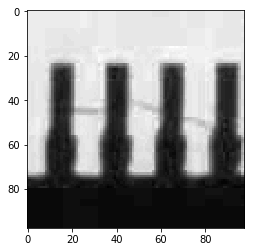

2


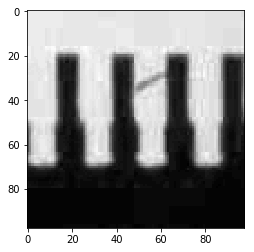

2


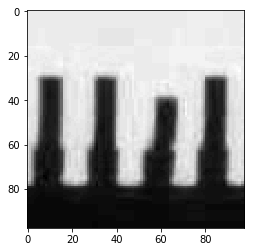

2


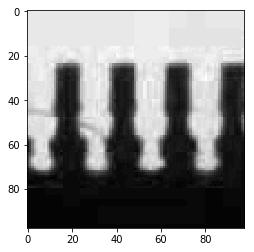

2


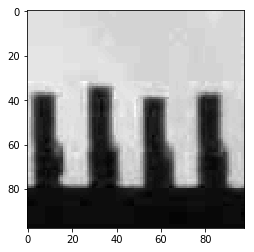

2


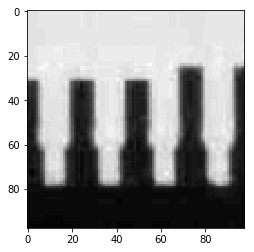

2


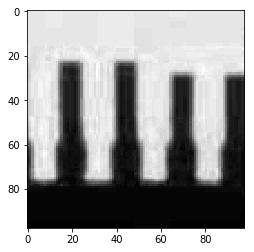

2


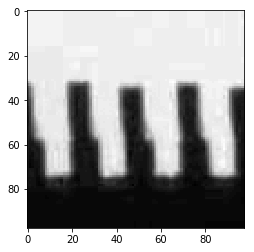

2


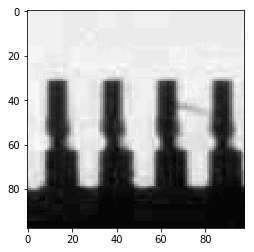

2


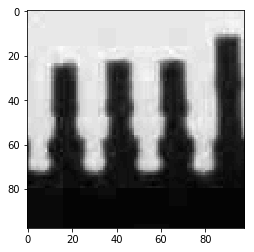

2


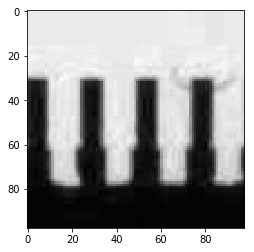

2


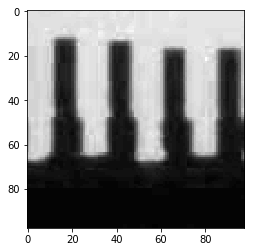

2


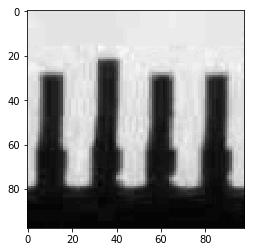

2


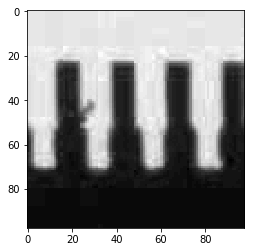

2


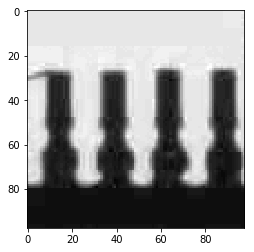

2


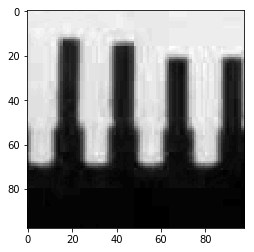

2


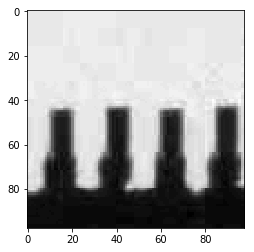

2


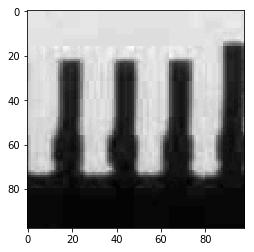

2


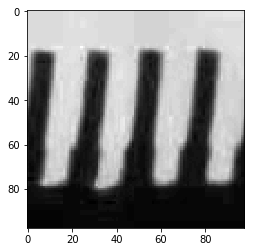

2


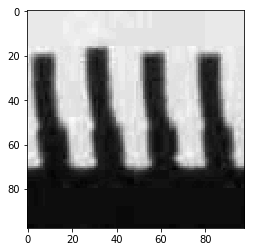

2


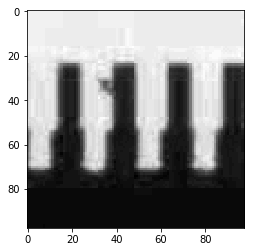

2


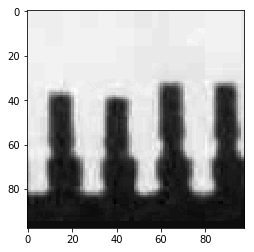

2


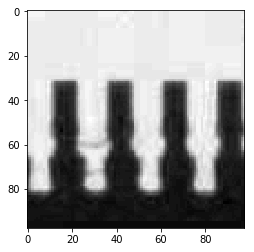

2


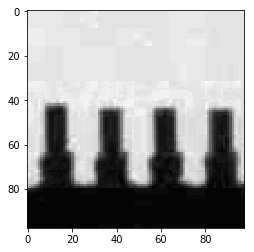

2


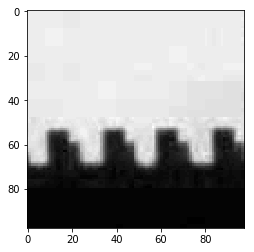

2


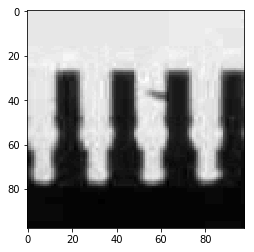

2


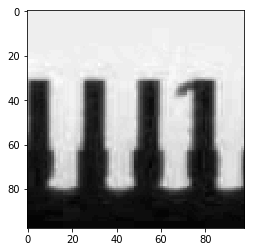

2


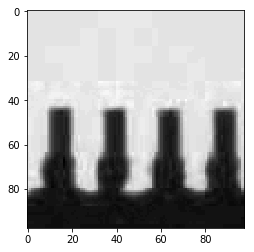

2


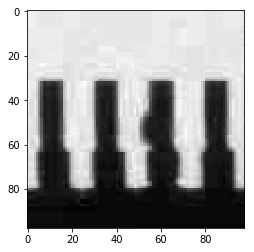

2


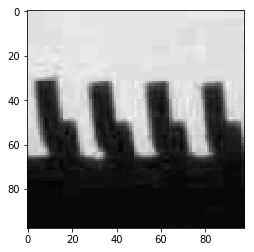

2


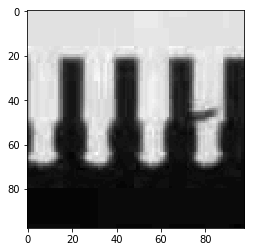

2


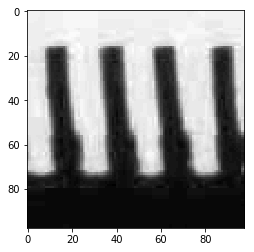

2


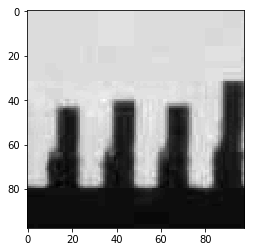

2


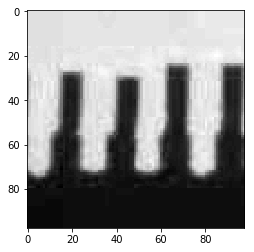

2


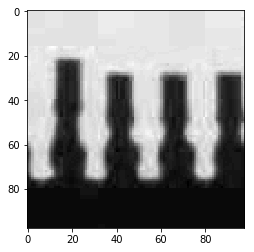

2


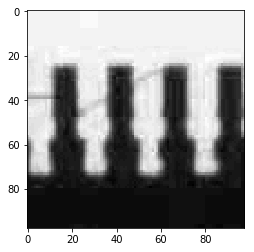

2


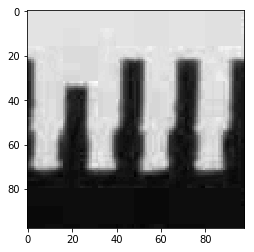

2


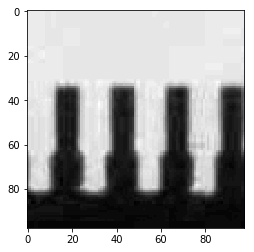

2


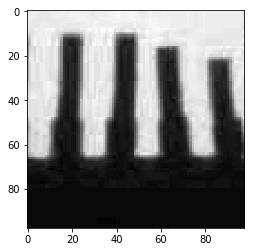

2


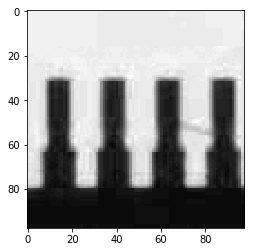

2


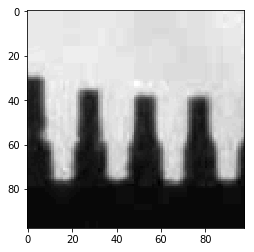

2


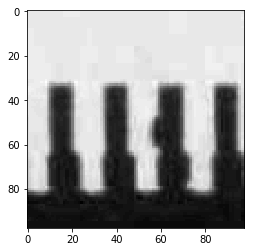

2


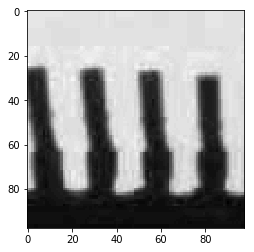

2


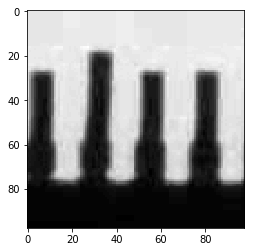

2


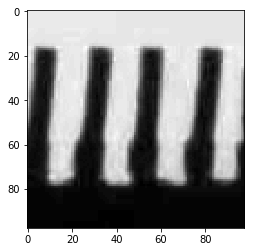

2


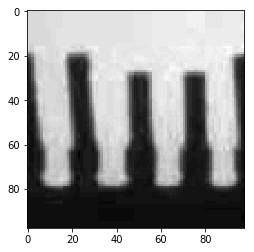

2


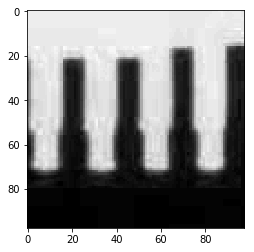

2


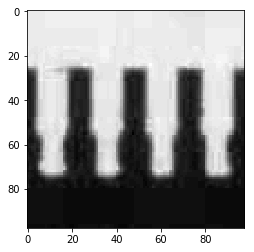

2


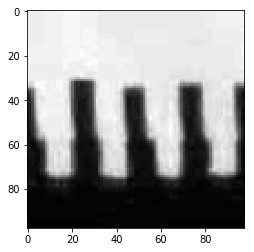

2


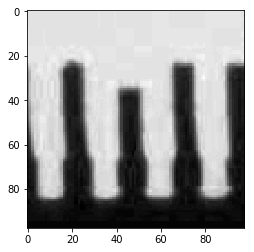

2


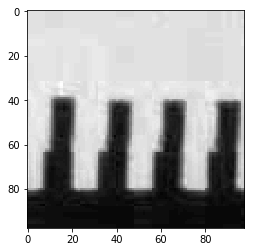

2


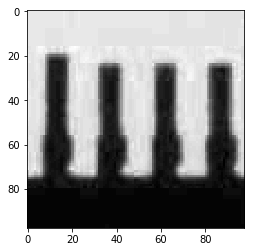

2


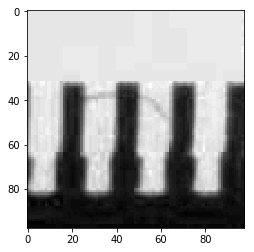

2


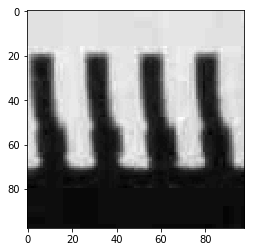

2


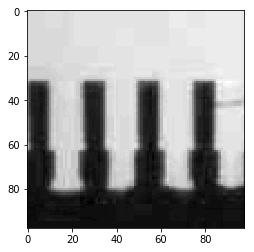

2


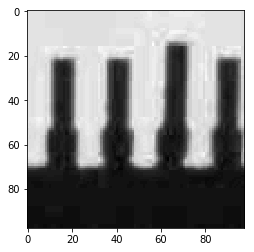

2


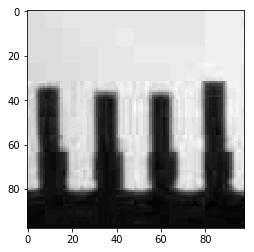

2


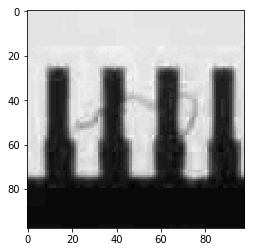

2


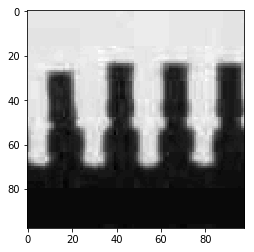

2


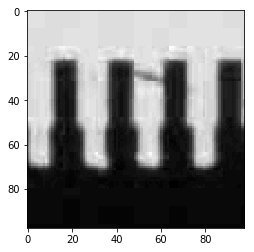

2


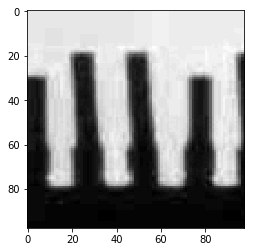

2


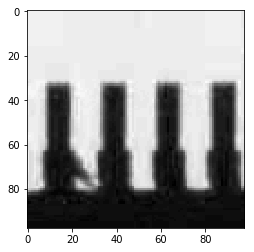

2


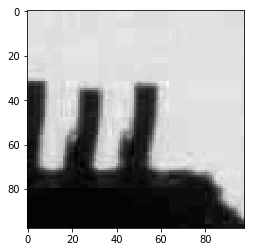

2


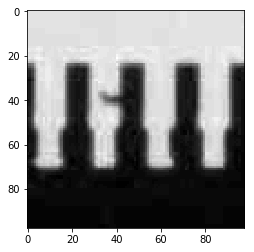

2


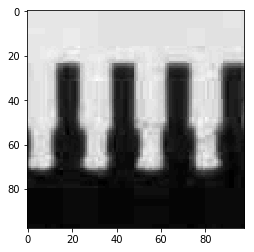

2


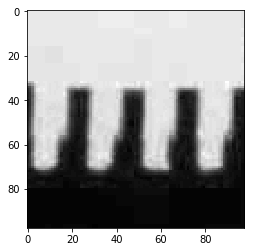

2


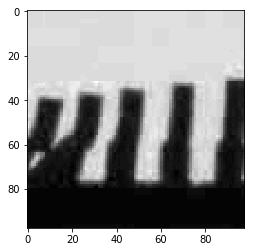

2


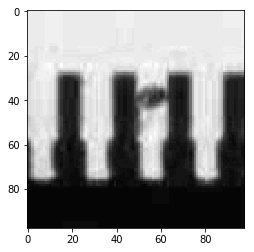

2


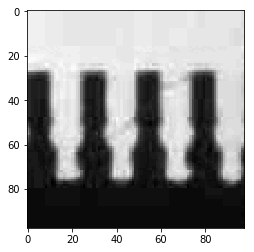

2


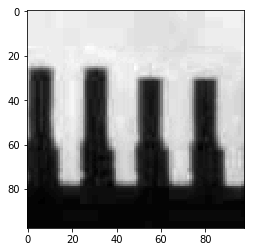

2


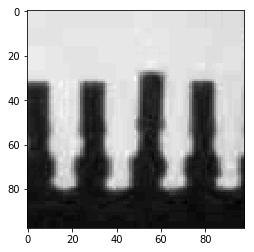

2


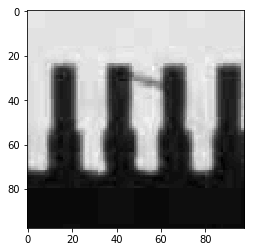

2


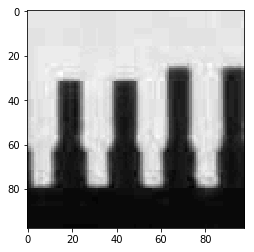

2


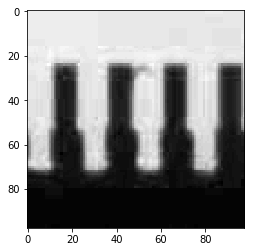

2


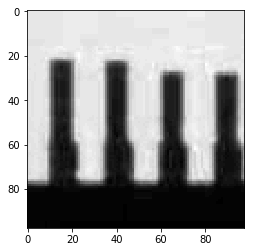

2


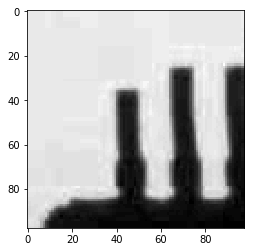

2


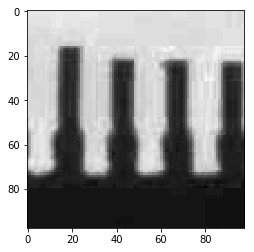

2


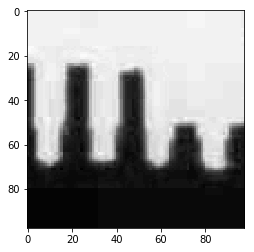

2


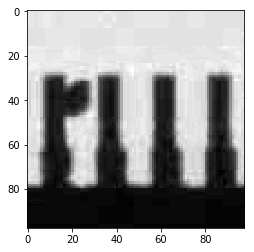

2


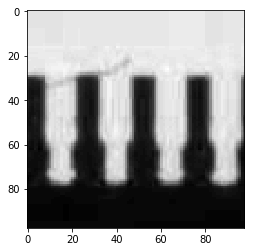

2


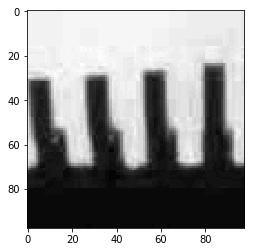

2


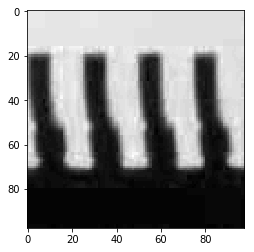

2


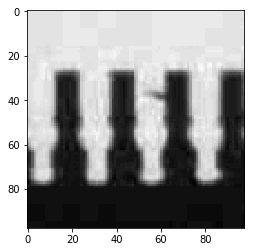

2


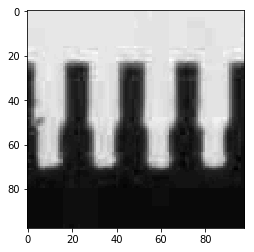

2


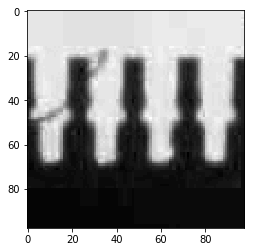

2


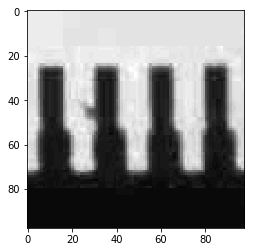

2


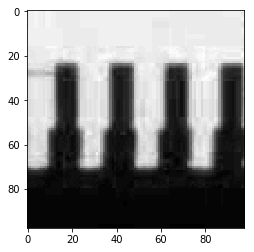

2


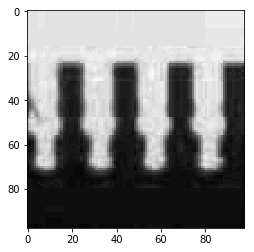

2


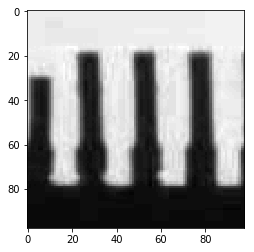

2


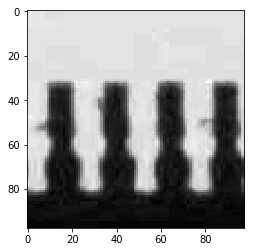

2


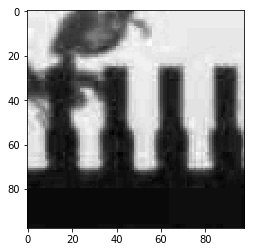

2


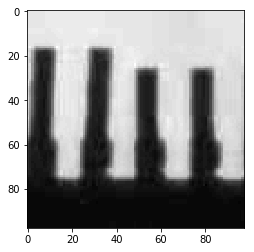

2


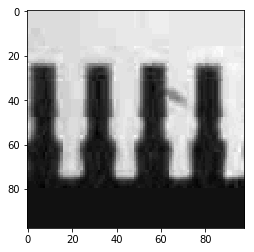

2


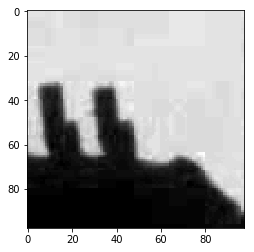

2


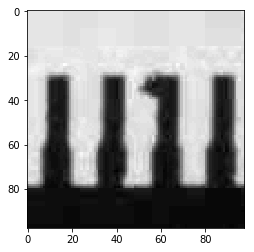

2


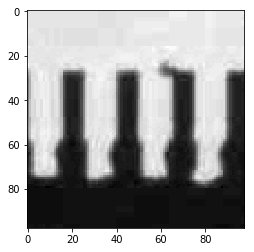

2


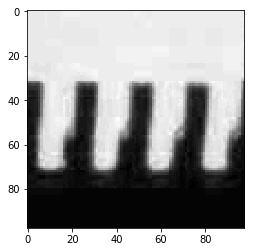

2


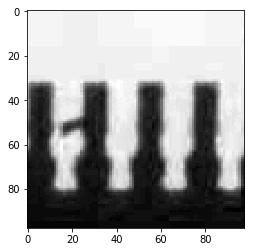

2


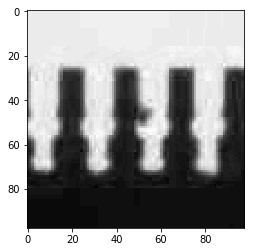

2


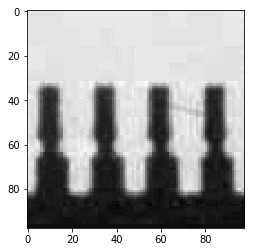

2


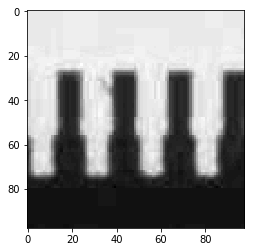

2


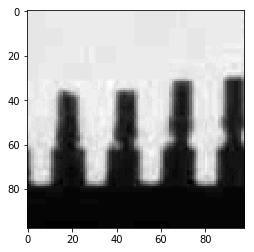

2


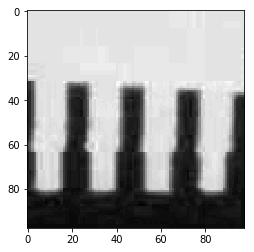

2


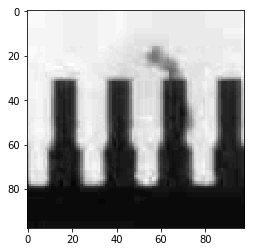

2


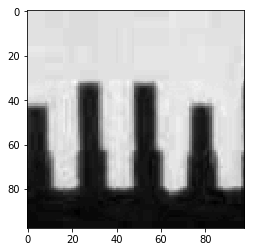

2


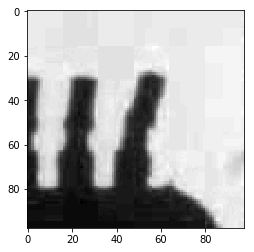

2


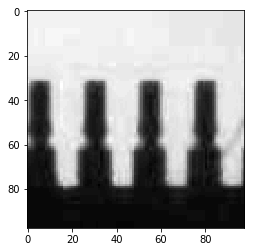

2


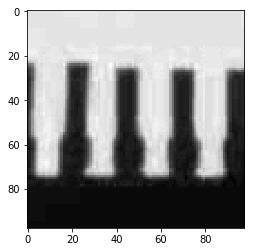

2


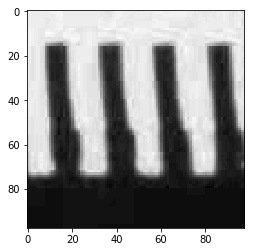

2


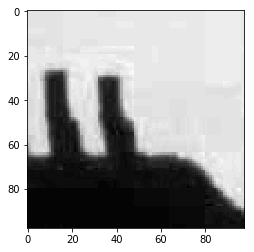

2


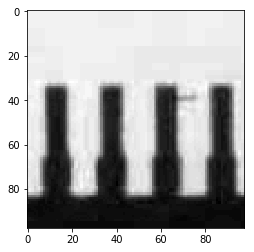

2


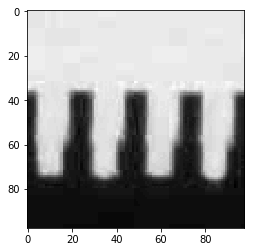

2


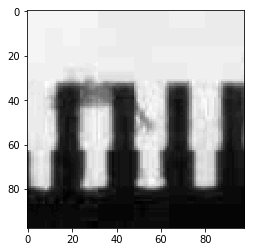

2


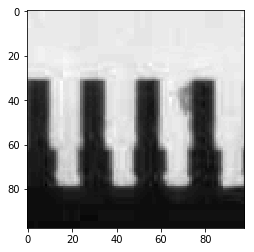

2


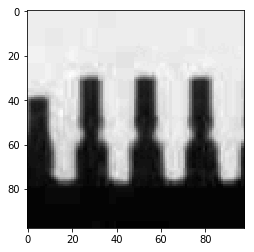

2


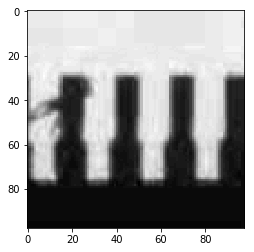

2


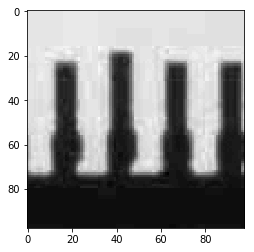

2


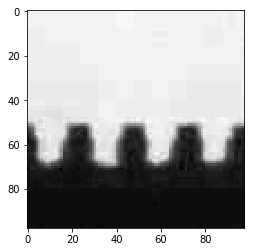

2


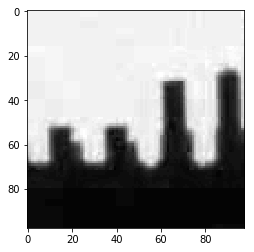

2


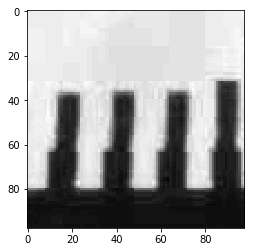

2


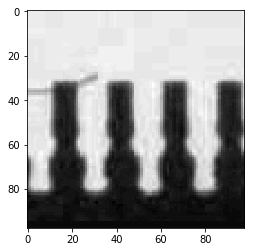

2


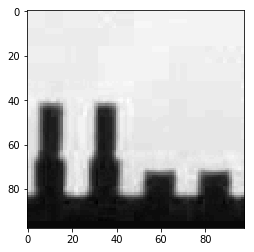

2


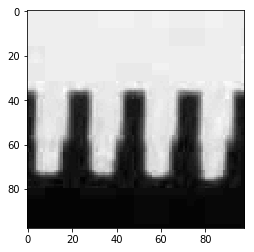

2


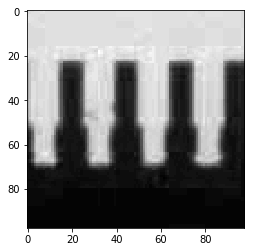

2


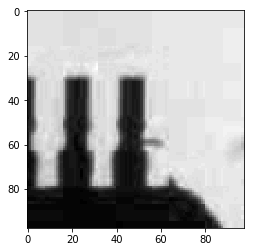

2


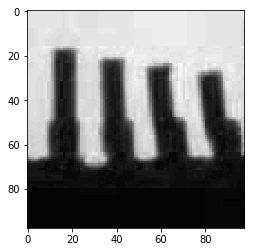

2


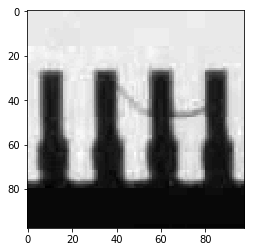

2


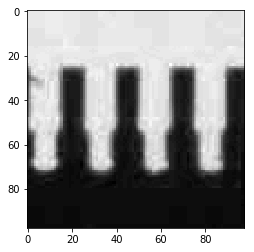

2


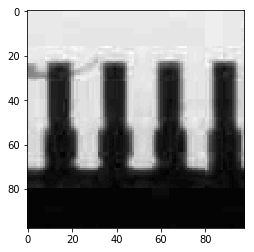

2


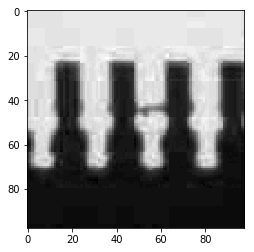

2


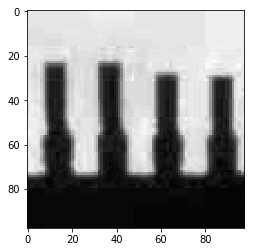

2


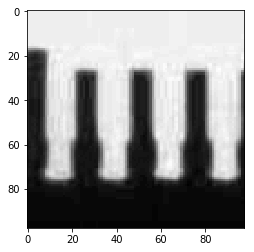

2


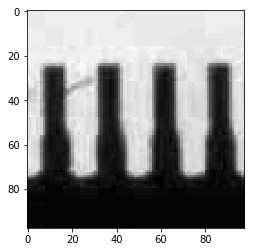

2


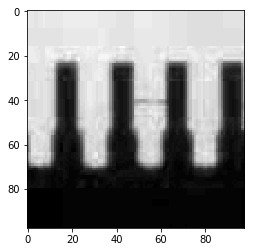

2


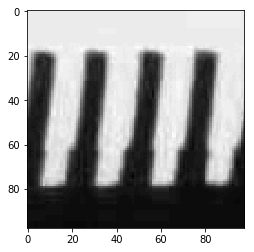

2


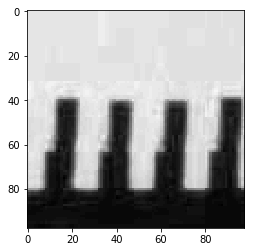

2


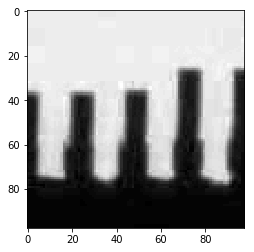

2


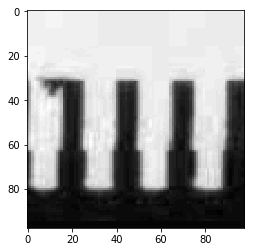

2


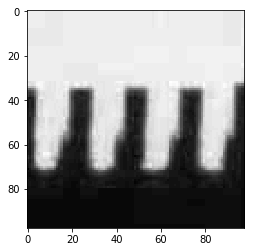

2


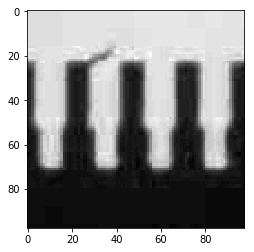

2


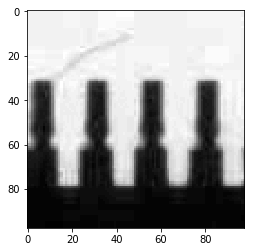

2


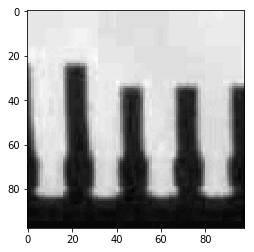

2


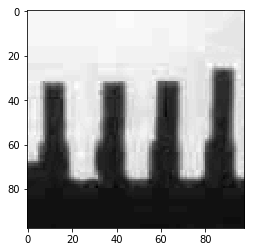

2


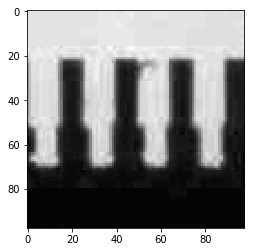

2


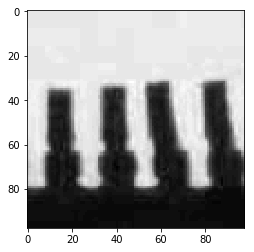

2


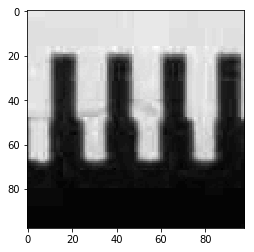

2


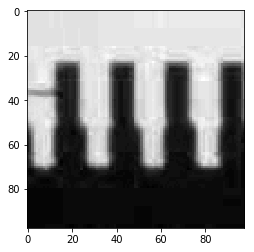

2


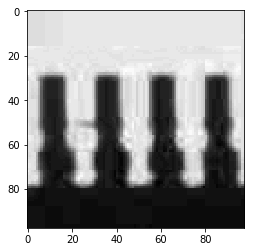

2


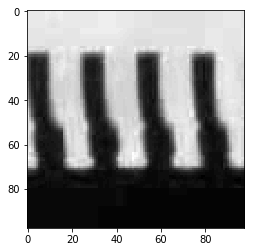

2


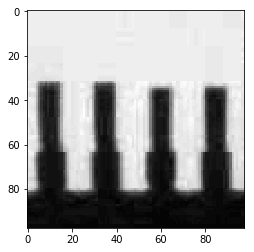

2


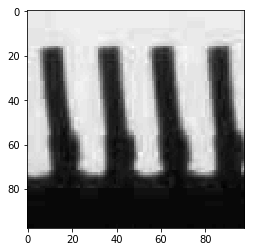

2


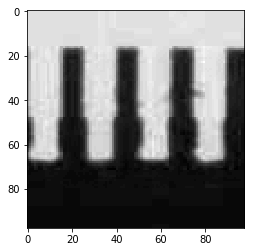

2


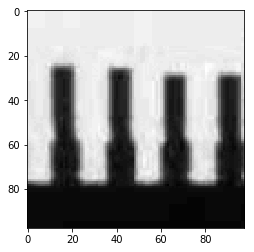

2


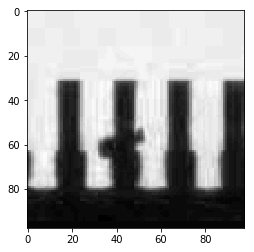

2


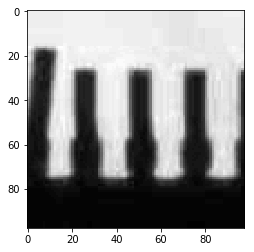

2


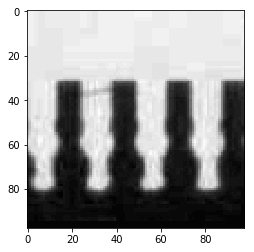

2


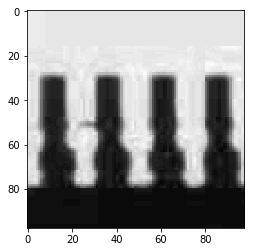

2


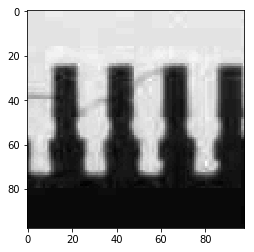

2


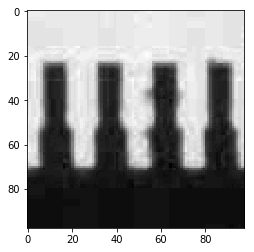

2


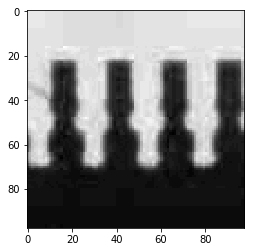

2


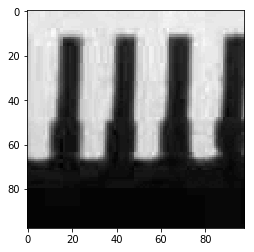

2


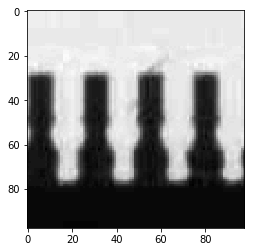

2


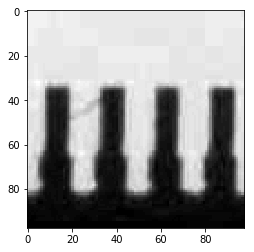

2


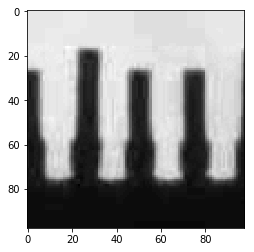

2


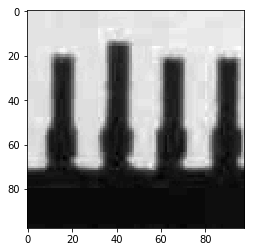

2


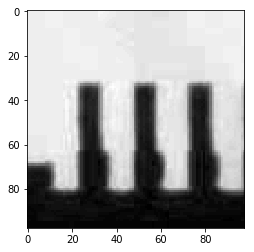

2


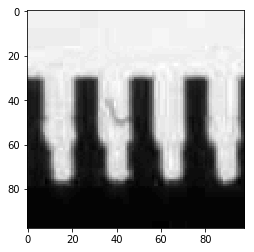

2


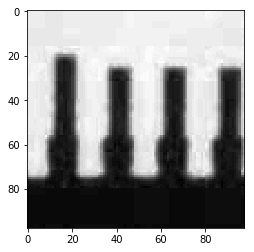

2


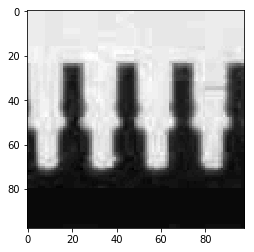

2


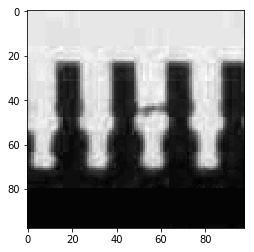

2


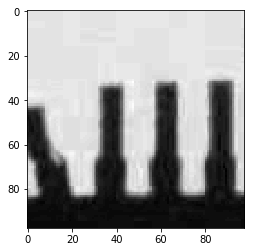

2


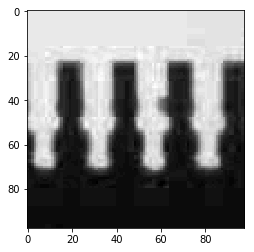

2


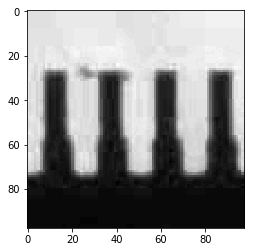

2


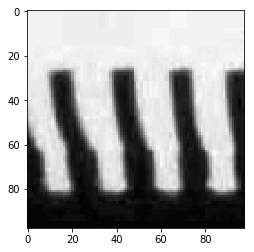

2


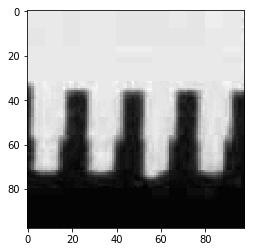

2


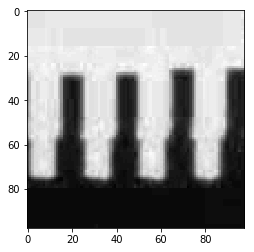

2


KeyboardInterrupt: 

In [32]:
print(kmeans.labels_[kmeans.labels_==1].shape)
 
for i,(_,img) in enumerate(loss_lists[0]):
    
    img=img.reshape(98,98)
    if kmeans.labels_[i]==2:
        print (kmeans.labels_[i]) 
        plt.imshow(img,cmap='gray')
        plt.show()

In [ ]:
import pickle 
with open('clusters.pkl','wb') as f:
    pickle.dump(kmeans, f)
with open('clusters.pkl','rb') as f:
    km=pickle.load(f)
km.predict(np_features)